<a href="https://colab.research.google.com/github/CalculatedContent/WeightWatcher/blob/master/WW_MLP3_BatchSizes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows that 
# Alpha decreases with increasing Test Accuracy

## But if alpha < 2, the model may be overtrained

### This is the simplest possible modern MLP, 3 layers trained on MNIST

- Using Keras, following this sample code:
    - https://www.kaggle.com/sathianpong/3-ways-to-implement-mlp-with-keras

- trained  with a early stopping on the training loss, 
    - upto 1000 epochs (but usually < 100)
    - delta_min = 0.001
- all layers are frozen, except for layer 1 (which is 300 x 100)
- the batch size is varied to induce the effect at very small batch_sizes


Note: To apply the theory in this way, it is necessary to:
- to train the all models  for as long / to as high of accuracy as possible 
- with the exact same initial conditions 

We don't necessarily need to freeze the other layers, but this is done for clarity here.  







## Keras Sequential API

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from IPython.display import Image, clear_output

sns.set()
tf.__version__

'2.8.2'

In [ ]:
# https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras

%env CUBLAS_WORKSPACE_CONFIG=:4096:8

import random
def reset_random_seeds(seed_value=42):
   os.environ['PYTHONHASHSEED']=str(seed_value)
   tf.random.set_seed(seed_value)
   tf.keras.utils.set_random_seed(seed_value)
   np.random.seed(seed_value)
   random.seed(seed_value)
   tf.config.experimental.enable_op_determinism()

reset_random_seeds()

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [ ]:
!pip install weightwatcher

### Download the Fashion MNIST dataset

In [ ]:
data = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = data.load_data()
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

clear_output()
print("X_train shape :",X_train.shape)
print("X_test shape :", X_test.shape)

X_train shape : (60000, 28, 28)
X_test shape : (10000, 28, 28)


### Recale the data

In [ ]:
X_train = X_train/255.0
X_test = X_test/255.0

### Build the simplest MLP, need 3 layers

- input layer
- hidden layer
- output layer

Initialize all models with the same weight matrices

In [ ]:
def build_model():

  reset_random_seeds()

  initializer = tf.keras.initializers.GlorotNormal(seed=1)

  # Specify the loss fuction, optimizer, metrics
  model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape = [28,28]),
      tf.keras.layers.Dense(300, activation='relu', kernel_initializer=initializer),
      tf.keras.layers.Dense(100, activation='relu', kernel_initializer=initializer),
      tf.keras.layers.Dense(10, activation='softmax', kernel_initializer=initializer),
  ])


  model.compile(
  loss = tf.keras.losses.SparseCategoricalCrossentropy(),
  optimizer = tf.keras.optimizers.SGD(),
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
  )

  model.layers[0].trainable = False
  model.layers[1].trainable = True
  model.layers[2].trainable = False
  model.layers[3].trainable = False

  return model



In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 235,500
Non-trainable params: 31,110
_________________________________________________________________


In [ ]:


model = build_model()
    
history = model.fit(
  X_train, y_train, epochs=1, batch_size=16, verbose=2 
)

3750/3750 - 10s - loss: 0.6044 - sparse_categorical_accuracy: 0.7953 - 10s/epoch - 3ms/step


### Should be:

3750/3750 - 9s - loss: 0.6044 - sparse_categorical_accuracy: 0.7953 - 9s/epoch - 2ms/step






In [ ]:
model = build_model()
    
history = model.fit(
  X_train, y_train, epochs=1, batch_size=16, verbose=2 
)

3750/3750 - 6s - loss: 0.6044 - sparse_categorical_accuracy: 0.7953 - 6s/epoch - 2ms/step


In [ ]:
# Train the model
def train_model(bs):
    
    model = build_model()
    
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=0, min_delta=0.001, restore_best_weights=True)
    history = model.fit(
        X_train, y_train, epochs=1000, batch_size=bs,
        validation_split=0.1,
        verbose=0, callbacks=[early_stopping_callback]
    )
    return model, history

In [ ]:

model, H = train_model(bs=16)

In [ ]:
H.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

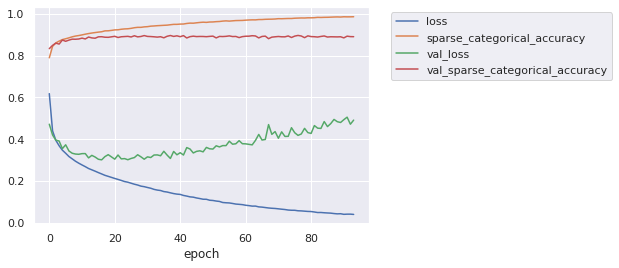

In [ ]:
pd.DataFrame(H.history).plot()
plt.xlabel("epoch")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [ ]:
import weightwatcher as ww
watcher = ww.WeightWatcher(model=model)
watcher.describe()

INFO:weightwatcher:

python      version 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
numpy       version 1.21.6
tensforflow version 2.8.2
keras       version 2.8.0
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': False, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': False, 'smooth': None, 

,layer_id,name,M,N,layer_type,num_evals,rf
0,1,None,300.0,784.0,LAYER_TYPE.DENSE,300.0,1.0
1,2,None,100.0,300.0,LAYER_TYPE.DENSE,100.0,1.0
2,3,None,10.0,100.0,LAYER_TYPE.DENSE,10.0,1.0


INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to ww-img


Assuming nested distributions


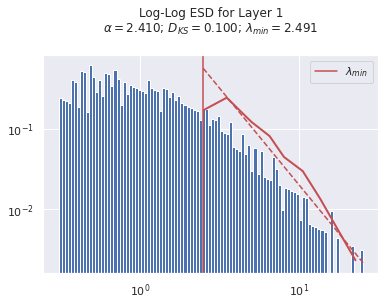

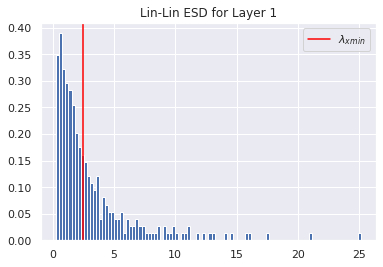

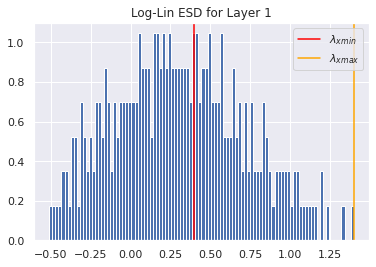

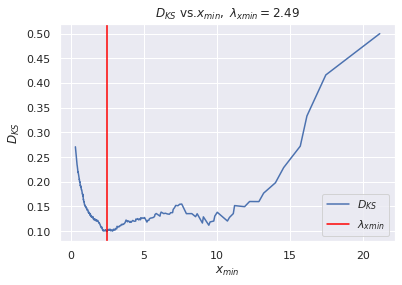

<Figure size 432x288 with 0 Axes>

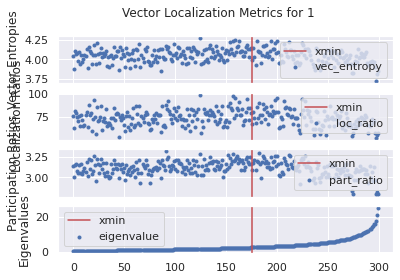

<Figure size 432x288 with 0 Axes>

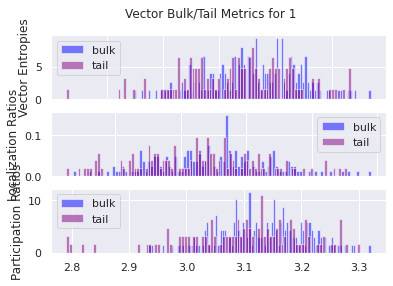

Assuming nested distributions


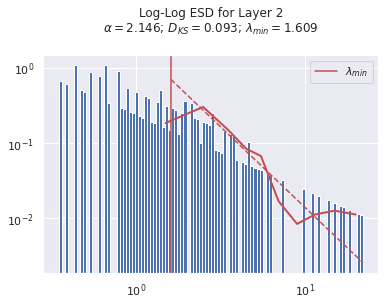

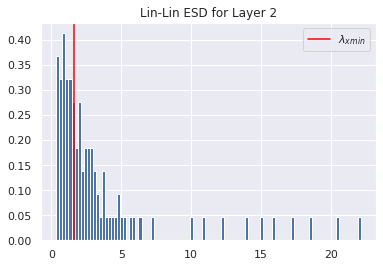

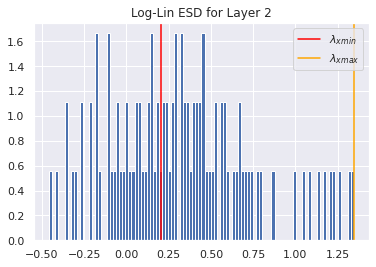

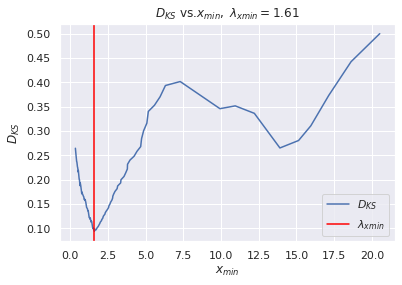

<Figure size 432x288 with 0 Axes>

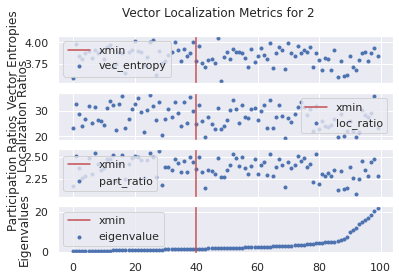

<Figure size 432x288 with 0 Axes>

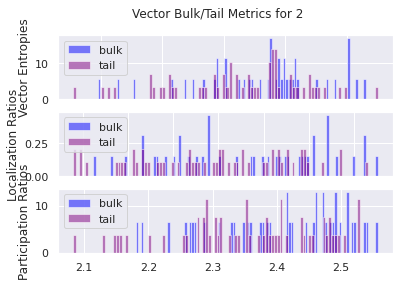

Assuming nested distributions
/usr/local/lib/python3.7/dist-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


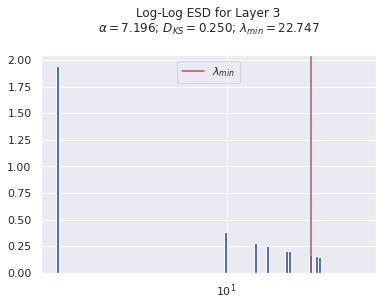

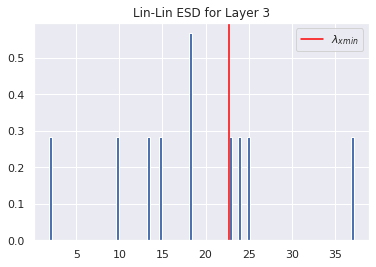

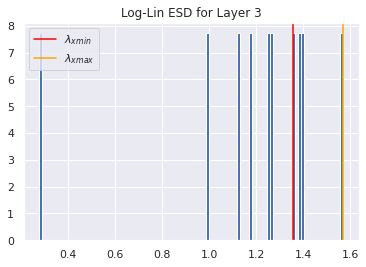

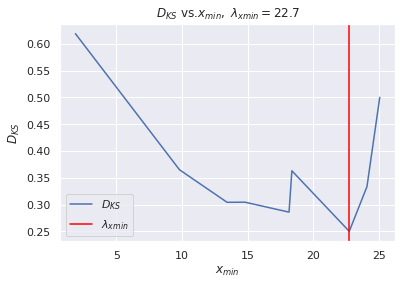

<Figure size 432x288 with 0 Axes>

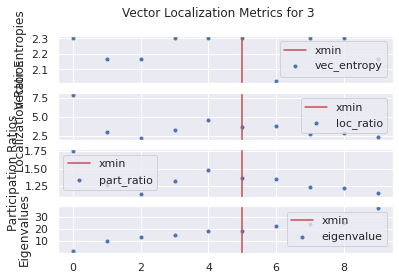

<Figure size 432x288 with 0 Axes>

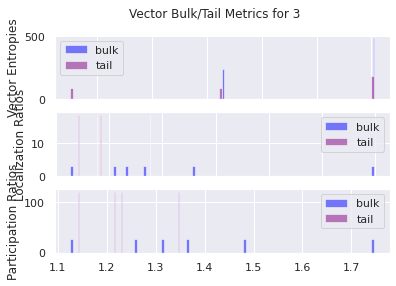

,layer_id,name,D,Lambda,M,N,alpha,alpha_weighted,best_fit,bulk_mean_loc_ratio,...,sv_max,tail_mean_loc_ratio,tail_mean_part_ratio,tail_mean_vec_entropy,tail_var_loc_ratio,tail_var_part_ratio,tail_var_vec_entropy,warning,xmax,xmin
0,1,None,0.099701,-1.0,300.0,784.0,2.409967,3.373588,truncated_power_law,74.822488,...,5.010996,72.830118,3.098451,4.032564,87.713803,0.010751,0.009015,success,25.110081,2.490500
1,2,None,0.093427,-1.0,100.0,300.0,2.145839,2.885572,truncated_power_law,29.017597,...,4.702886,27.107535,2.354810,3.826117,17.231643,0.011852,0.011019,success,22.117138,1.608746
2,3,None,0.250000,-1.0,10.0,100.0,7.195963,11.297924,lognormal,4.147899,...,6.095625,2.949961,1.234284,2.198613,0.252800,0.005502,0.013212,under-trained,37.156643,22.747202


<Figure size 432x288 with 0 Axes>

In [ ]:
watcher.analyze(plot=True)

### We can now vary the hyperparameters and see how the test accuracy changes
 > defaults: https://keras.io/api/optimizers/sgd/'

The goal is to get some significant variation in the test (validation) accuraies, and see how our weightwatcher metrics compare

Analyzing MLP3 bs=1


INFO:weightwatcher:

python      version 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
numpy       version 1.21.6
tensforflow version 2.8.2
keras       version 2.8.0
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': [1]}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:Filtering layer by id 1


Assuming nested distributions


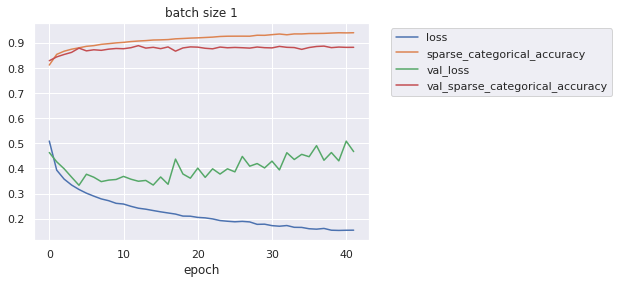

Analyzing MLP3 bs=2


INFO:weightwatcher:

python      version 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
numpy       version 1.21.6
tensforflow version 2.8.2
keras       version 2.8.0
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': [1]}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:Filtering layer by id 1


Assuming nested distributions


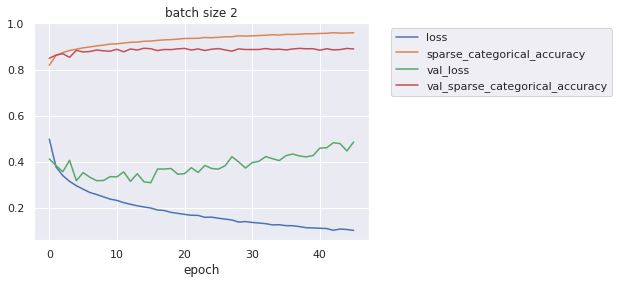

Analyzing MLP3 bs=4


INFO:weightwatcher:

python      version 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
numpy       version 1.21.6
tensforflow version 2.8.2
keras       version 2.8.0
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': [1]}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:Filtering layer by id 1


Assuming nested distributions


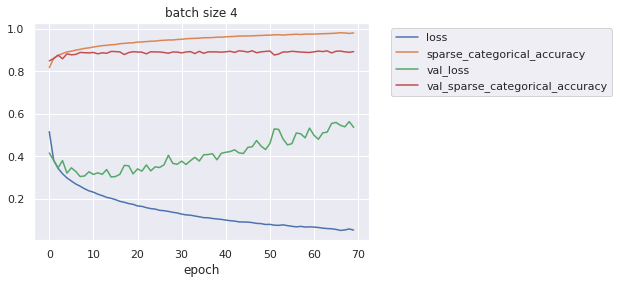

Analyzing MLP3 bs=8


INFO:weightwatcher:

python      version 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
numpy       version 1.21.6
tensforflow version 2.8.2
keras       version 2.8.0
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': [1]}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:Filtering layer by id 1


Assuming nested distributions


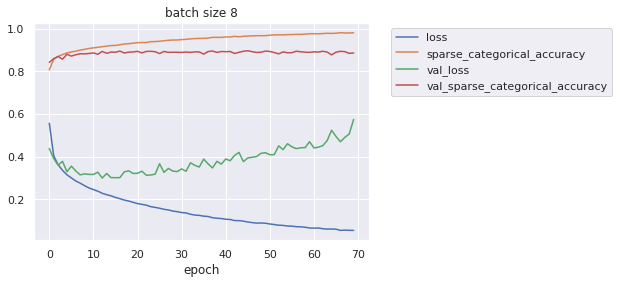

Analyzing MLP3 bs=16


INFO:weightwatcher:

python      version 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
numpy       version 1.21.6
tensforflow version 2.8.2
keras       version 2.8.0
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': [1]}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:Filtering layer by id 1


Assuming nested distributions


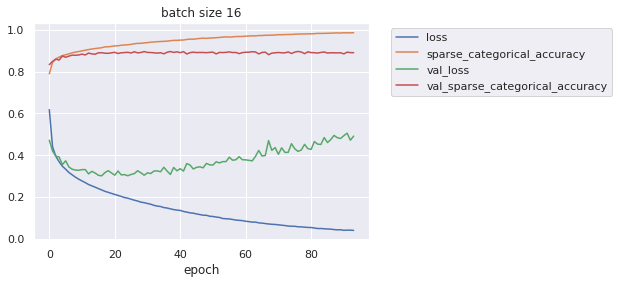

Analyzing MLP3 bs=32


INFO:weightwatcher:

python      version 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
numpy       version 1.21.6
tensforflow version 2.8.2
keras       version 2.8.0
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': False, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': False, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': [1]}
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:Filtering layer by id 1


Assuming nested distributions


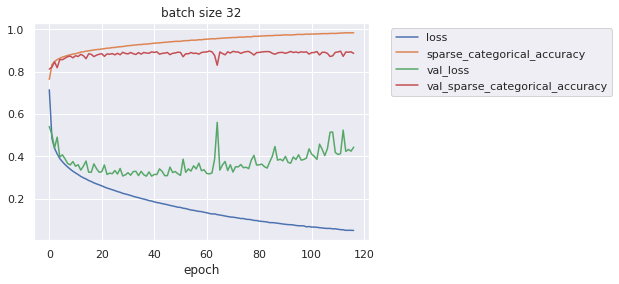

In [ ]:
# Changes just the learning rate first
all_reaults = []
#all_bs = [256,128,64,13,16,8,4,2, 1]
all_bs = [1,2,4,8,16,32]


mlp3_results = None
models = {}
histories = {}
for bs in all_bs:
    layer_ids = [1]
    modelname = 'MLP3'
    print(f"Analyzing {modelname} bs={bs}")
    model, H = train_model(bs)
    watcher = ww.WeightWatcher(model=model)
    results = watcher.analyze(layers=layer_ids)

    val_acc = H.history['val_sparse_categorical_accuracy'][-1]

    histories[bs] = H
    models[bs]= model

    results['modelname'] = modelname
    results['batch_size'] = bs
    results['H_val_acc'] = H.history['val_sparse_categorical_accuracy'][-1]


    score = model.evaluate(X_train, y_train, verbose = 0) 
    results['train_accuracy'] = score[1]
    score = model.evaluate(X_test, y_test, verbose = 0) 
    results['test_accuracy'] = score[1]


    pd.DataFrame(H.history).plot()
    plt.xlabel("epoch")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.title(f"batch size {bs}")
    plt.show()

    #filename = f"/content/drive/My Drive/MLP3/model_bs{bs}"
    #model.save(filename)
    
    if mlp3_results is None:
        mlp3_results = results
    else:
        mlp3_results = pd.concat((mlp3_results, results))

#filename = f"/content/drive/My Drive/MLP3/mlp3_results.feather"
#mlp3_results.to_feather(filename)

Text(0, 0.5, 'Test Accuracy')

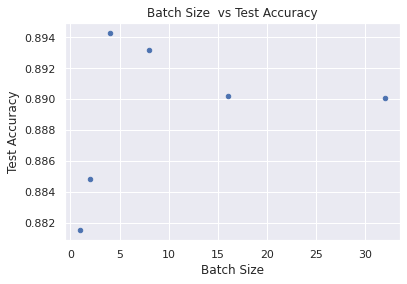

In [ ]:
mlp3_results.plot.scatter(x='batch_size',y='test_accuracy')
plt.title(r"Batch Size  vs Test Accuracy")
plt.xlabel(r"Batch Size")
plt.ylabel("Test Accuracy")

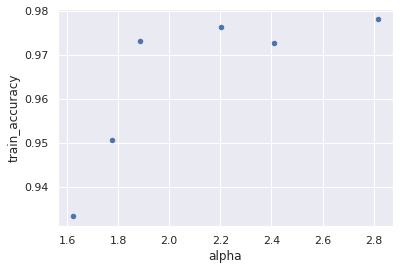

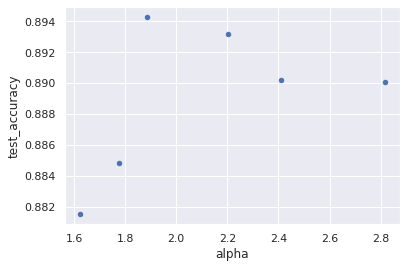

In [ ]:
mlp3_results.plot.scatter(x='alpha',y='train_accuracy')
mlp3_results.plot.scatter(x='alpha',y='test_accuracy')

Text(0, 0.5, 'Test Accuracy')

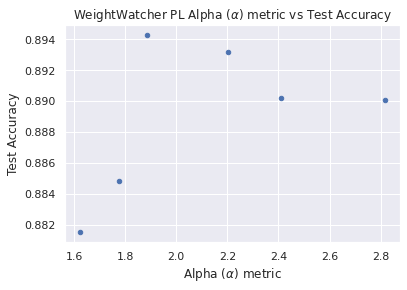

In [ ]:
mlp3_results.plot.scatter(x='alpha',y='test_accuracy')
plt.title(r"WeightWatcher PL Alpha ($\alpha$) metric vs Test Accuracy")
plt.xlabel(r"Alpha ($\alpha$) metric")
plt.ylabel("Test Accuracy")

KeyboardInterrupt: ignored